In [1]:
import pathlib
import json

In [2]:
import influxdb
import pandas as pd

In [3]:
from odapi.connectors import Irceline
from odapi.settings import settings
settings.logger.setLevel(50)

## Parameters

In [4]:
t0 = pd.Timestamp('2020-06-22 12:45:00', tz='CET').tz_convert('UTC')
t0 = pd.Timestamp('2020-06-20 12:45:00', tz='CET').tz_convert('UTC')
t0

Timestamp('2020-06-20 10:45:00+0000', tz='UTC')

In [5]:
t1 = pd.Timestamp.utcnow()
t1

Timestamp('2020-06-22 12:41:23.034079+0000', tz='UTC')

## Irceline Reference

In [6]:
cref = Irceline()

In [7]:
sel = cref.select(sitekey='41', measurekey='PM')

In [8]:
sel.shape

(11, 25)

In [9]:
recs = cref.get_records(sel, start=t0, stop=t1)

In [10]:
keys = ['measurekey', 'sitekey', 'serieid']

In [11]:
dref = recs.merge(sel[keys]).pivot_table(index='start', columns=keys, values='value')

In [12]:
dref.tail()

measurekey                PM-10.0                                    PM-2.5  \
sitekey                    41B011 41MEU1 41N043 41R001 41R012 41WOL1 41B011   
serieid                      6531   6552   6563   6578   6626   6643   6532   
start                                                                         
2020-06-22 07:00:00+00:00     NaN   21.0   34.5   22.5   25.0   23.0    NaN   
2020-06-22 08:00:00+00:00     NaN   22.0   31.0   22.0    NaN   19.0    NaN   
2020-06-22 09:00:00+00:00    12.0   13.0   23.0   19.0   18.0   14.5   4.60   
2020-06-22 10:00:00+00:00    11.5   16.0   19.5   16.0    NaN   15.5   4.45   
2020-06-22 11:00:00+00:00     NaN   20.0   25.0   18.5   19.0   14.0    NaN   

measurekey                                             
sitekey                   41MEU1 41N043 41R001 41R012  
serieid                     6553   6564   6579   6627  
start                                                  
2020-06-22 07:00:00+00:00   12.5  15.85   7.45   11.6  
2020-06-22 08:00:00+00:00   10.9  15.90   8.65    NaN  
2020-06-22 09:00:00+00:00   11.3  10.60   9.05    7.6  
2020-06-22 10:00:00+00:00    8.1   8.15   7.25    NaN  
2020-06-22 11:00:00+00:00   15.9  10.95   7.25    9.7

## SDS Benchmark

In [13]:
with pathlib.Path('C:/Users/admin/udlog/influx.json').open() as fh:
    client = influxdb.InfluxDBClient(**json.load(fh))

In [14]:
client.ping()

'1.8.0'

In [15]:
query = """
SELECT mean(pm25) AS pm25, mean(pm10) AS pm10
FROM "home"
WHERE time >= '{start:}' AND time < '{stop:}'
GROUP BY time(1h)
""".format(start=t0.isoformat(), stop=t1.isoformat())
print(query)


SELECT mean(pm25) AS pm25, mean(pm10) AS pm10
FROM "home"
WHERE time >= '2020-06-20T10:45:00+00:00' AND time < '2020-06-22T12:41:23.034079+00:00'
GROUP BY time(1h)



In [16]:
r = client.query(query).raw['series'][0]

In [17]:
dsds = pd.DataFrame(r['values'], columns=r['columns'])
dsds['time'] = pd.to_datetime(dsds['time'])
dsds = dsds.set_index('time')
dsds.columns = pd.MultiIndex.from_tuples([('PM-2.5', 'Home', '1'), ('PM-10.0', 'Home', '2')])
dsds.tail()

,PM-2.5,PM-10.0
,Home,Home
,1,2
time,,
2020-06-22 08:00:00+00:00,NaN,NaN
2020-06-22 09:00:00+00:00,14.055760,26.623656
2020-06-22 10:00:00+00:00,75.963322,140.174151
2020-06-22 11:00:00+00:00,6.081676,17.273886
2020-06-22 12:00:00+00:00,5.506470,18.668095


## Data Merge

In [18]:
df = pd.concat([dref, dsds], axis=1)
df.tail()

measurekey                PM-10.0                                    PM-2.5  \
sitekey                    41B011 41MEU1 41N043 41R001 41R012 41WOL1 41B011   
serieid                      6531   6552   6563   6578   6626   6643   6532   
2020-06-22 08:00:00+00:00     NaN   22.0   31.0   22.0    NaN   19.0    NaN   
2020-06-22 09:00:00+00:00    12.0   13.0   23.0   19.0   18.0   14.5   4.60   
2020-06-22 10:00:00+00:00    11.5   16.0   19.5   16.0    NaN   15.5   4.45   
2020-06-22 11:00:00+00:00     NaN   20.0   25.0   18.5   19.0   14.0    NaN   
2020-06-22 12:00:00+00:00     NaN    NaN    NaN    NaN    NaN    NaN    NaN   

measurekey                                                           PM-10.0  
sitekey                   41MEU1 41N043 41R001 41R012       Home        Home  
serieid                     6553   6564   6579   6627          1           2  
2020-06-22 08:00:00+00:00   10.9  15.90   8.65    NaN        NaN         NaN  
2020-06-22 09:00:00+00:00   11.3  10.60   9.05    7.6  14.055760   26.623656  
2020-06-22 10:00:00+00:00    8.1   8.15   7.25    NaN  75.963322  140.174151  
2020-06-22 11:00:00+00:00   15.9  10.95   7.25    9.7   6.081676   17.273886  
2020-06-22 12:00:00+00:00    NaN    NaN    NaN    NaN   5.506470   18.668095

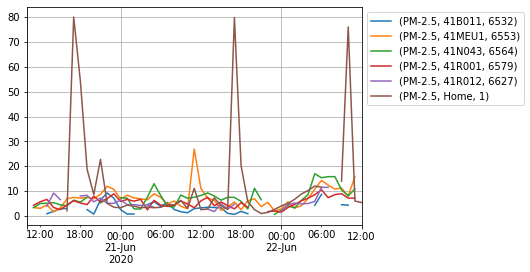

In [19]:
axe = df.filter(regex='2.5').plot()
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

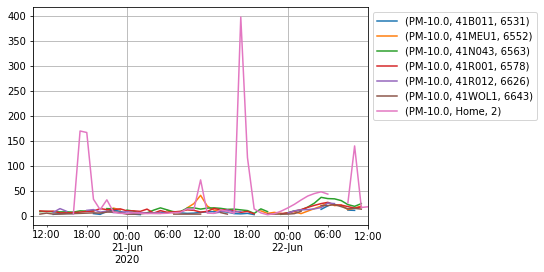

In [20]:
axe = df.filter(regex='10.0').plot()
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

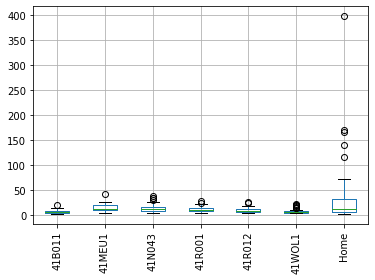

In [21]:
axe = df.filter(regex='10.0').droplevel([0,-1], axis=1).boxplot(rot=90)

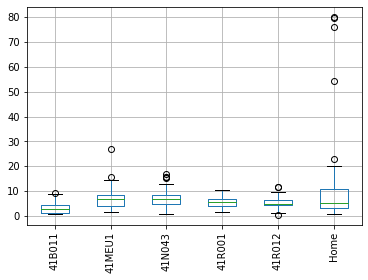

In [22]:
axe = df.filter(regex='2.5').droplevel([0,-1], axis=1).boxplot(rot=90)